Import

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size


Load data

In [2]:
###################################################################################################
# Load data 
###################################################################################################
from snowflake.snowpark.context import get_active_session
import snowflake.snowpark.functions as f
session = get_active_session()
taxi_raw_df = session.table("NY_TAXI_DATA.RAW.TAXI_DATA")
data = taxi_raw_df.to_pandas()


In [2]:
weather_raw_df = session.table("NY_TAXI_DATA.RAW.WEATHER")
weather = weather_raw_df.to_pandas()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Clean, conform data

In [5]:
data['PICKUP_DATETIME'] = pd.to_datetime(data.PICKUP_DATETIME)
data.loc[:, 'PICKUP_DATE'] = data['PICKUP_DATETIME'].dt.date
data['DROPOFF_DATETIME'] = pd.to_datetime(data.DROPOFF_DATETIME)
#convert the following into a binary 1 indicator column
data['STORE_AND_FWD_FLAG'] = 1 * (data.STORE_AND_FWD_FLAG.values == 'Y')

In [6]:
long_trip = data['TRIP_DURATION'].max() 
print('The longest recorded ride in the dataset: ' + str(long_trip) )

The longest recorded ride in the dataset (in hours): 979


In [7]:
short_trip = data['TRIP_DURATION'].min() 
print('The shortest recorded ride in the dataset: ' + str(short_trip) )

The shortest recorded ride in the dataset (in hours): 0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 12 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int32
trip_duration         1458644 non-null int64
pickup_date           1458644 non-null object
dtypes: datetime64[ns](2), float64(4), int32(1), int64(3), object(2)
memory usage: 128.0+ MB


In [9]:
data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude  store_and_fwd_flag  trip_duration pickup_date  
0         40.765602                   0            455  2016-03-14  
1         40.731152                   0            663  2016-06-12  
2         40.710087                   0           2124  2016-01-19  
3         40.706718                   0            429  2016-04-06  
4         40.782520                   0            435  2016-03-26

Trip duration is in seconds

In [10]:
data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  
count       1.458644e+06      1.458644e+06        1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01        5.515396e-03   9.594923e+02  
std         7.064327e-02      3.589056e-02        7.406066e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01        0.000000e+00   1.000000e+00  
25%        -7.399133e+01      4.073588e+01        0.000000e+00   3.970000e+02  
50%        -7.397975e+01      4.075452e+01        0.000000e+00   6.620000e+02  
75%        -7.396301e+01      4.076981e+01        0.000000e+00   1.075000e+03  
max        -6.133553e+01      4.392103e+01        1.000000e+00   3.526282e+06

small note here that it seems very unlikely that the maximum trip duration was 3.5M seconds long (10+ hours), and the minimum trip duration also 1 second long. The trips with these values must have been recorded as a mistake. 

In [11]:
weather.head(60)

date  maximum temperature  minimum temperature  average temperature  \
0    1-1-2016                   42                   34                 38.0   
1    2-1-2016                   40                   32                 36.0   
2    3-1-2016                   45                   35                 40.0   
3    4-1-2016                   36                   14                 25.0   
4    5-1-2016                   29                   11                 20.0   
5    6-1-2016                   41                   25                 33.0   
6    7-1-2016                   46                   31                 38.5   
7    8-1-2016                   46                   31                 38.5   
8    9-1-2016                   47                   40                 43.5   
9   10-1-2016                   59                   40                 49.5   
10  11-1-2016                   40                   26                 33.0   
11  12-1-2016                   44                   25                 34.5   
12  13-1-2016                   30                   22                 26.0   
13  14-1-2016                   38                   22                 30.0   
14  15-1-2016                   51                   34                 42.5   
15  16-1-2016                   52                   42                 47.0   
16  17-1-2016                   42                   30                 36.0   
17  18-1-2016                   31                   18                 24.5   
18  19-1-2016                   28                   16                 22.0   
19  20-1-2016                   37                   27                 32.0   
20  21-1-2016                   36                   26                 31.0   
21  22-1-2016                   30                   21                 25.5   
22  23-1-2016                   27                   24                 25.5   
23  24-1-2016                   35                   20                 27.5   
24  25-1-2016                   39                   28                 33.5   
25  26-1-2016                   48                   38                 43.0   
26  27-1-2016                   47                   34                 40.5   
27  28-1-2016                   42                   32                 37.0   
28  29-1-2016                   41                   30                 35.5   
29  30-1-2016                   39                   28                 33.5   
30  31-1-2016                   56                   36                 46.0   
31   1-2-2016                   59                   44                 51.5   
32   2-2-2016                   50                   38                 44.0   
33   3-2-2016                   59                   42                 50.5   
34   4-2-2016                   59                   44                 51.5   
35   5-2-2016                   44                   31                 37.5   
36   6-2-2016                   40                   30                 35.0   
37   7-2-2016                   47                   33                 40.0   
38   8-2-2016                   39                   28                 33.5   
39   9-2-2016                   36                   27                 31.5   
40  10-2-2016                   39                   31                 35.0   
41  11-2-2016                   31                   18                 24.5   
42  12-2-2016                   27                   15                 21.0   
43  13-2-2016                   22                    6                 14.0   
44  14-2-2016                   15                   -1                  7.0   
45  15-2-2016                   35                   13                 24.0   
46  16-2-2016                   54                   35                 44.5   
47  17-2-2016                   39                   35                 37.0   
48  18-2-2016                   36                   27                 31.5   
49  19-2-

In [12]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
date                   366 non-null object
maximum temperature    366 non-null int64
minimum temperature    366 non-null int64
average temperature    366 non-null float64
precipitation          366 non-null object
snow fall              366 non-null object
snow depth             366 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


on a side note, it seems in 2016, there was a February 29th, which makes for 366 days in a year.

In [3]:
weather.DATE =  pd.to_datetime(weather.DATE)

In [4]:
weather['PRECIPITATION'].unique()


array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

Weather data collected from the National Weather Service. It contains the first six months of 2016, for a weather station in central park. It contains for each day the minimum temperature, maximum temperature, average temperature, precipitation, new snow fall, and current snow depth. The temperature is measured in Fahrenheit and the depth is measured in inches. T means that there is a trace of precipitation.

For our purposes, T is as good as 0, since it is not quantifiable.

In [5]:
weather['PRECIPITATION'] = np.where(weather['PRECIPITATION']=='T', '0.00',weather['PRECIPITATION'])
weather['PRECIPITATION'] = list(map(float, weather['PRECIPITATION']))

In [6]:
weather['SNOW_FALL'] = np.where(weather['SNOW_FALL']=='T', '0.00',weather['SNOW_FALL'])
weather['SNOW_FALL'] = list(map(float, weather['SNOW_FALL']))
weather['SNOW_DEPTH'] = np.where(weather['SNOW_DEPTH']=='T', '0.00',weather['SNOW_DEPTH'])
weather['SNOW_DEPTH'] = list(map(float, weather['SNOW_DEPTH']))

In [17]:
data['DATE'] = pd.to_datetime(data['PICKUP_DATE'])
train = pd.merge(data, weather[['DATE','MINIMUM_TEMPERATURE', 'PRECIPITATION', 'SNOW_FALL', 'SNOW_DEPTH']], on= 'DATE', how = 'left')
data.shape[0]

1458644

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
id                     1458644 non-null object
vendor_id              1458644 non-null int64
pickup_datetime        1458644 non-null datetime64[ns]
dropoff_datetime       1458644 non-null datetime64[ns]
passenger_count        1458644 non-null int64
pickup_longitude       1458644 non-null float64
pickup_latitude        1458644 non-null float64
dropoff_longitude      1458644 non-null float64
dropoff_latitude       1458644 non-null float64
store_and_fwd_flag     1458644 non-null int32
trip_duration          1458644 non-null int64
pickup_date            1458644 non-null object
date                   1458644 non-null datetime64[ns]
minimum temperature    1458644 non-null int64
precipitation          1458644 non-null float64
snow fall              1458644 non-null float64
snow depth             1458644 non-null float64
dtypes: datetime64[ns](3), float64(7), int32(1), int64(4), obj

In [19]:
train['LOG_TRIP_DURATION'] = np.log(train['TRIP_DURATION'].values + 1)

In [20]:
#getting rid of data points where the trip duration is more than 2 std. dev. away from the mean.
#plotting the log(trip duration) shows us that the distribution is roughhly normal.
#even with this filter, we can expect to retain about 95% of the orginal dataset.

m = np.mean(train['TRIP_DURATION'])
s = np.std(train['TRIP_DURATION'])
train = train[train['TRIP_DURATION'] <= m + 2*s]
train = train[train['TRIP_DURATION'] >= m - 2*s]

In [21]:
train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.456540e+06     1.456540e+06      1.456540e+06     1.456540e+06   
mean   1.534291e+00     1.663941e+00     -7.397349e+01     4.075093e+01   
std    4.988229e-01     1.313611e+00      7.091177e-02     3.286533e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  \
count       1.456540e+06      1.456540e+06        1.456540e+06   1.456540e+06   
mean       -7.397342e+01      4.075180e+01        5.523364e-03   8.368576e+02   
std         7.067435e-02      3.588810e-02        7.411383e-02   6.589297e+02   
min        -1.219333e+02      3.218114e+01        0.000000e+00   1.000000e+00   
25%        -7.399133e+01      4.073589e+01        0.000000e+00   3.970000e+02   
50%        -7.397975e+01      4.075453e+01        0.000000e+00   6.620000e+02   
75%        -7.396302e+01      4.076981e+01        0.000000e+00   1.073000e+03   
max        -6.133553e+01      4.392103e+01        1.000000e+00   1.141100e+04   

       minimum temperature  precipitation     snow fall    snow depth  \
count         1.456540e+06   1.456540e+06  1.456540e+06  1.456540e+06   
mean          4.673203e+01   8.851502e-02  5.855967e-02  4.064042e-01   
std           1.571627e+01   2.336874e-01  9.393728e-01  2.246270e+00   
min          -1.000000e+00   0.000000e+00  0.000000e+00  0.000000e+00   
25%           3.600000e+01   0.000000e+00  0.000000e+00  0.000000e+00   
50%           4.600000e+01   0.000000e+00  0.000000e+00  0.000000e+00   
75%           6.100000e+01   4.000000e-02  0.000000e+00  0.000000e+00   
max           7.500000e+01   2.310000e+00  2.730000e+01  2.200000e+01   

       log_trip_duration  
count       1.456540e+06  
mean        6.460025e+00  
std         7.748918e-01  
min         6.931472e-01  
25%         5.986452e+00  
50%         6.496775e+00  
75%         6.979145e+00  
max         9.342421e+00

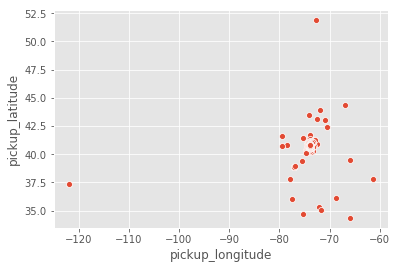

In [22]:
sns.scatterplot(data=train, x='PICKUP_LONGITUDE', y='PICKUP_LATITUDE')

alot of them are centered around new york city, but some data points seem to be coming from afar. Filtering with the known geolocation coordinates for NYC we get the following:

the borders of NYC<br>
city_long_border = (-74.03, -73.75) <br>
city_lat_border = (40.63, 40.85) 

In [23]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train.PICKUP_LATITUDE> south) & (train.PICKUP_LATITUDE < north)]
train = train[(train.DROPOFF_LATITUDE> south) & (train.DROPOFF_LATITUDE < north)]
train = train[(train.PICKUP_LONGITUDE> west) & (train.PICKUP_LONGITUDE < east)]
train = train[(train.DROPOFF_LONGITUDE> west) & (train.DROPOFF_LONGITUDE < east)]

In [24]:
train.shape[0]

1436572

we still have more than 1.43M data observations.

In [1]:
#ccredit to beluga kernel

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    x = np.sin(lng_delta_rad) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(x, y))

In [27]:
train.loc[:, 'distance_haversine'] = haversine_array(train['PICKUP_LATITUDE'].values, train['PICKUP_LONGITUDE'].values, train['DROPOFF_LATITUDE'].values, train['DROPOFF_LONGITUDE'].values)

train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['PICKUP_LATITUDE'].values, train['PICKUP_LONGITUDE'].values, train['DROPOFF_LATITUDE'].values, train['DROPOFF_LONGITUDE'].values)

train.loc[:, 'direction'] = bearing_array(train['PICKUP_LATITUDE'].values, train['PICKUP_LONGITUDE'].values, train['DROPOFF_LATITUDE'].values, train['DROPOFF_LONGITUDE'].values)

The above function and the cell below calculate the haversine distance (aka great sphere distance in km), the corresponding "manhattan distance" (to describe a distance that a car would take in a gridlike city in km), and the bearing direction in degrees.


In [28]:
snowpark_df = session.write_pandas(train, "NY_TAXI_DATA.CLEAN.CLEAN_TEST", auto_create_table=True)
snowpark_df.to_pandas()

Now apply the same cleaning to the test data from "test.csv" file, so that we don't have to do it later.

In [7]:
#taxi_raw_df = session.table("NY_TAXI_DATA.RAW.TAXI_DATA")
taxi_raw_test_df = session.table("NY_TAXI_DATA.RAW.TAXI_DATA_TEST")
test = taxi_raw_test_df.to_pandas()

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [8]:
test['PICKUP_DATETIME'] = pd.to_datetime(test.PICKUP_DATETIME)
test.loc[:, 'PICKUP_DATE'] = test['PICKUP_DATETIME'].dt.date

#convert the following into a binary 1 indicator column
test['STORE_AND_FWD_FLAG'] = 1 * (test.STORE_AND_FWD_FLAG.values == 'Y')

In [9]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

test = test[(test.PICKUP_LATITUDE> south) & (test.PICKUP_LATITUDE < north)]
test = test[(test.DROPOFF_LATITUDE> south) & (test.DROPOFF_LATITUDE < north)]
test = test[(test.PICKUP_LONGITUDE> west) & (test.PICKUP_LONGITUDE < east)]
test = test[(test.DROPOFF_LONGITUDE> west) & (test.DROPOFF_LONGITUDE < east)]

In [10]:
test['DATE'] = pd.to_datetime(test['PICKUP_DATE'])
test_merge = pd.merge(test, weather[['DATE','MINIMUM_TEMPERATURE', 'PRECIPITATION', 'SNOW_FALL', 'SNOW_DEPTH']], on= 'DATE', how = 'left')

In [13]:
test.loc[:, 'distance_haversine'] = haversine_array(test['PICKUP_LATITUDE'].values, test['PICKUP_LONGITUDE'].values, test['DROPOFF_LATITUDE'].values, test['DROPOFF_LONGITUDE'].values)

test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['PICKUP_LATITUDE'].values, test['PICKUP_LONGITUDE'].values, test['DROPOFF_LATITUDE'].values, test['DROPOFF_LONGITUDE'].values)

test.loc[:, 'direction'] = bearing_array(test['PICKUP_LATITUDE'].values, test['PICKUP_LONGITUDE'].values, test['DROPOFF_LATITUDE'].values, test['DROPOFF_LONGITUDE'].values)

In [14]:
#test.info()
session.sql('USE SCHEMA NY_TAXI_DATA.CLEAN;').collect()
snowpark_df2 = session.write_pandas(test, "CLEAN_TRAIN", auto_create_table=True)
snowpark_df2.to_pandas()